# Q3-1: Price Sensitivity Analysis

## 🎯 Objective

Analyze how demand (trip count) responds to price changes across different price levels.

**Key Question:** When prices increase, does demand decrease? When prices decrease, does demand increase?

## 📊 Methodology

### Step 1: Create Price Categories
- Calculate **relative price** for each trip compared to the median price of the same zone-hour
- Divide into 3 categories using fixed thresholds (±10%):
  - **Low**: `relative_price < 0.90` (cheaper by >10%)
  - **Medium**: `0.90 ≤ relative_price ≤ 1.10` (normal price, ±10%)
  - **High**: `relative_price > 1.10` (expensive by >10%)

### Step 2: Aggregate to Panel Data
- Group by: `(PULocationID, pickup_hour, pickup_dayofweek)`
- Calculate: `avg_price` and `trip_count` for each group

### Step 3: Compare Demand Across Price Categories
- **Bar Chart**: Average trip_count by price category
- **Scatter Plot**: Price vs Demand relationship with trend line
- **Percentage Changes**: Calculate % change in demand between High/Medium/Low

## 💡 Why Relative Price?

Using relative price (compared to zone-hour median) instead of absolute price:
- ✅ Controls for location and time effects
- ✅ Isolates pure price impact (closer to causal inference)
- ✅ Avoids misclassifying low-demand areas as "low price"
- ✅ More stable and interpretable (±10% thresholds)


In [8]:
# Q3-1: Price Sensitivity Analysis - Data Preparation
import sys
from pathlib import Path

# Add project root to Python path
# Find project root by looking for src/data_loader.py
current = Path.cwd()
project_root = current
while project_root != project_root.parent:
    if (project_root / "src" / "data_loader.py").exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

import polars as pl
from src.data_loader import TLCDataLoader

# Initialize loader
loader = TLCDataLoader(str(project_root / "data" / "raw"))


TLCDataLoader initialized with 12 monthly files.


In [9]:
# Load raw columns needed for analysis
df = loader.load(
    features=["PULocationID", "pickup_datetime", "trip_miles", "base_passenger_fare"],
    months=["2024-01", "2024-02", "2024-03"],  # Start with Q1 for testing
    sample_ratio=0.1  # Use 10% sample for quick testing
)

print(f"Loaded {len(df):,} trips")
print(df.head())


Selected 3 files: ['fhvhv_tripdata_2024-01.parquet', 'fhvhv_tripdata_2024-02.parquet', 'fhvhv_tripdata_2024-03.parquet']
Loading columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Ready columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Loaded 6,047,021 trips
shape: (5, 4)
┌──────────────┬─────────────────────┬────────────┬─────────────────────┐
│ PULocationID ┆ pickup_datetime     ┆ trip_miles ┆ base_passenger_fare │
│ ---          ┆ ---                 ┆ ---        ┆ ---                 │
│ i32          ┆ datetime[μs]        ┆ f64        ┆ f64                 │
╞══════════════╪═════════════════════╪════════════╪═════════════════════╡
│ 76           ┆ 2024-01-01 00:53:41 ┆ 1.215      ┆ 18.8                │
│ 90           ┆ 2024-01-01 00:33:55 ┆ 1.43       ┆ 9.14                │
│ 157          ┆ 2024-01-01 00:06:26 ┆ 3.1        ┆ 17.85               │
│ 56           ┆ 2024-01-01 00:42:58 ┆ 9.36       ┆ 27.04               

In [10]:
# Step 1: Data cleaning - filter invalid trips
print(f"Before cleaning: {len(df):,} trips")
df = df.filter(
    (pl.col("trip_miles") > 0) & 
    (pl.col("trip_miles") < 100) &
    (pl.col("base_passenger_fare") > 0)
)
print(f"After cleaning: {len(df):,} trips")

# Step 2: Calculate avg_price_per_mile
# This is the cleanest price proxy:
# - base_passenger_fare (not total fare) = pricing decision
# - Divided by miles = comparable across distances
df = df.with_columns([
    (pl.col("base_passenger_fare") / pl.col("trip_miles")).alias("price_per_mile")
])

# Step 3: Extract time features from pickup_datetime
df = df.with_columns([
    pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
    pl.col("pickup_datetime").dt.weekday().alias("pickup_dayofweek")  # 1=Monday, 7=Sunday
])

print("\nAdded features:")
print(df.select(["PULocationID", "pickup_hour", "pickup_dayofweek", "price_per_mile"]).head())


Before cleaning: 6,047,021 trips
After cleaning: 6,044,073 trips

Added features:
shape: (5, 4)
┌──────────────┬─────────────┬──────────────────┬────────────────┐
│ PULocationID ┆ pickup_hour ┆ pickup_dayofweek ┆ price_per_mile │
│ ---          ┆ ---         ┆ ---              ┆ ---            │
│ i32          ┆ i8          ┆ i8               ┆ f64            │
╞══════════════╪═════════════╪══════════════════╪════════════════╡
│ 76           ┆ 0           ┆ 1                ┆ 15.473251      │
│ 90           ┆ 0           ┆ 1                ┆ 6.391608       │
│ 157          ┆ 0           ┆ 1                ┆ 5.758065       │
│ 56           ┆ 0           ┆ 1                ┆ 2.888889       │
│ 129          ┆ 0           ┆ 1                ┆ 4.553784       │
└──────────────┴─────────────┴──────────────────┴────────────────┘


In [11]:
# Step 4: Create panel by grouping
# Analysis unit: pickup_zone × pickup_hour × pickup_dayofweek
panel = df.group_by(["PULocationID", "pickup_hour", "pickup_dayofweek"]).agg([
    pl.col("price_per_mile").mean().alias("avg_price"),
    pl.col("price_per_mile").count().alias("trip_count")
]).sort(["PULocationID", "pickup_hour", "pickup_dayofweek"])

print(f"Panel shape: {panel.shape}")
print("\nFirst 10 rows:")
print(panel.head(10))


Panel shape: (42488, 5)

First 10 rows:
shape: (10, 5)
┌──────────────┬─────────────┬──────────────────┬───────────┬────────────┐
│ PULocationID ┆ pickup_hour ┆ pickup_dayofweek ┆ avg_price ┆ trip_count │
│ ---          ┆ ---         ┆ ---              ┆ ---       ┆ ---        │
│ i32          ┆ i8          ┆ i8               ┆ f64       ┆ u32        │
╞══════════════╪═════════════╪══════════════════╪═══════════╪════════════╡
│ 2            ┆ 9           ┆ 5                ┆ 4.445983  ┆ 1          │
│ 2            ┆ 11          ┆ 1                ┆ 3.962092  ┆ 1          │
│ 2            ┆ 12          ┆ 1                ┆ 2.888602  ┆ 1          │
│ 2            ┆ 15          ┆ 1                ┆ 4.0327    ┆ 1          │
│ 2            ┆ 16          ┆ 5                ┆ 4.189024  ┆ 1          │
│ 2            ┆ 16          ┆ 7                ┆ 3.07445   ┆ 1          │
│ 2            ┆ 17          ┆ 7                ┆ 6.079295  ┆ 1          │
│ 3            ┆ 0           ┆ 1             

## 📈 Analysis: Price Category Classification

Now we'll classify each observation into Low/Medium/High price categories based on relative price.

**Method:**
1. Calculate median price for each `(zone, hour)` combination
2. Compute relative price = `avg_price / median_price_zone_hour`
3. Classify using fixed thresholds:
   - **Low**: relative < 0.90 (cheaper by >10%)
   - **Medium**: 0.90 ≤ relative ≤ 1.10 (normal, ±10%)
   - **High**: relative > 1.10 (expensive by >10%)


In [12]:
# Check panel statistics
print("Panel Summary:")
print(panel.describe())
print(f"\nTotal unique combinations: {len(panel):,}")
print(f"Unique zones: {panel['PULocationID'].n_unique()}")
print(f"Unique hours: {panel['pickup_hour'].n_unique()}")
print(f"Unique day of week: {panel['pickup_dayofweek'].n_unique()}")


Panel Summary:
shape: (9, 6)
┌────────────┬──────────────┬─────────────┬──────────────────┬────────────┬────────────┐
│ statistic  ┆ PULocationID ┆ pickup_hour ┆ pickup_dayofweek ┆ avg_price  ┆ trip_count │
│ ---        ┆ ---          ┆ ---         ┆ ---              ┆ ---        ┆ ---        │
│ str        ┆ f64          ┆ f64         ┆ f64              ┆ f64        ┆ f64        │
╞════════════╪══════════════╪═════════════╪══════════════════╪════════════╪════════════╡
│ count      ┆ 42488.0      ┆ 42488.0     ┆ 42488.0          ┆ 42488.0    ┆ 42488.0    │
│ null_count ┆ 0.0          ┆ 0.0         ┆ 0.0              ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 134.012545   ┆ 11.55571    ┆ 4.003224         ┆ 6.560294   ┆ 142.253648 │
│ std        ┆ 75.884105    ┆ 6.906969    ┆ 2.000874         ┆ 2.608438   ┆ 153.944598 │
│ min        ┆ 2.0          ┆ 0.0         ┆ 1.0              ┆ 1.361868   ┆ 1.0        │
│ 25%        ┆ 67.0         ┆ 6.0         ┆ 2.0              ┆ 5.496031   ┆ 37.0 

In [18]:
# Q3-1: Price Sensitivity Analysis
# Method: Based on relative price (compared to zone-hour median)

# Step 1: Calculate median price for each zone-hour combination
# This gives us the baseline price for each location and time
zone_hour_median = panel.group_by(["PULocationID", "pickup_hour"]).agg([
    pl.col("avg_price").median().alias("median_price_zone_hour")
])

print("Step 1: Calculated median price per zone-hour")
print(f"  Unique zone-hour combinations: {len(zone_hour_median):,}")
print(zone_hour_median.head())

# Step 2: Join median price back to panel
panel = panel.join(zone_hour_median, on=["PULocationID", "pickup_hour"], how="left")

# Step 3: Calculate relative price
# relative_price = avg_price / median_price_of_that_zone_hour
panel = panel.with_columns([
    (pl.col("avg_price") / pl.col("median_price_zone_hour")).alias("relative_price")
])

print("\nStep 2 & 3: Added relative price")
print(panel.select(["PULocationID", "pickup_hour", "avg_price", "median_price_zone_hour", "relative_price"]).head(10))

# Step 4: Divide relative_price into 3 groups using fixed thresholds (±10%)
# This is more stable and doesn't depend on quantiles
# Low: relative_price < 0.90  (cheaper than baseline by >10%)
# Medium: 0.90 ≤ relative_price ≤ 1.10  (within ±10% of baseline)
# High: relative_price > 1.10  (more expensive than baseline by >10%)

print(f"\nRelative price thresholds (fixed, ±10% method):")
print(f"  Low:    relative_price < 0.90  (cheaper by >10%)")
print(f"  Medium: 0.90 ≤ relative_price ≤ 1.10  (normal price, ±10%)")
print(f"  High:   relative_price > 1.10  (expensive by >10%)")

# Create price category based on fixed relative price thresholds
panel = panel.with_columns([
    pl.when(pl.col("relative_price") < 0.90)
      .then(pl.lit("Low"))
      .when(pl.col("relative_price") <= 1.10)
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("High"))
      .alias("price_category")
])

print(f"\nPrice category distribution:")
print(panel["price_category"].value_counts().sort("price_category"))


Step 1: Calculated median price per zone-hour
  Unique zone-hour combinations: 6,175
shape: (5, 3)
┌──────────────┬─────────────┬────────────────────────┐
│ PULocationID ┆ pickup_hour ┆ median_price_zone_hour │
│ ---          ┆ ---         ┆ ---                    │
│ i32          ┆ i8          ┆ f64                    │
╞══════════════╪═════════════╪════════════════════════╡
│ 114          ┆ 18          ┆ 9.91786                │
│ 198          ┆ 7           ┆ 7.255082               │
│ 121          ┆ 1           ┆ 5.506222               │
│ 203          ┆ 11          ┆ 5.800247               │
│ 238          ┆ 1           ┆ 5.471839               │
└──────────────┴─────────────┴────────────────────────┘

Step 2 & 3: Added relative price
shape: (10, 5)
┌──────────────┬─────────────┬───────────┬────────────────────────┬────────────────┐
│ PULocationID ┆ pickup_hour ┆ avg_price ┆ median_price_zone_hour ┆ relative_price │
│ ---          ┆ ---         ┆ ---       ┆ ---                    

## 📖 Q3-2 白话解释

### 🎯 我们要做什么？

找出哪些地区的人**不在乎价格**（涨价也不会跑），哪些地区的人**超敏感**（一涨价就跑光）。

### 📝 步骤解释

#### Step 1: 把数据分组
- **做什么**：把每个「地区 × 时段 × 价格等级」的数据分组
- **为什么**：我们要看同一个地区、同一个时段，价格高/中/低时，客人数量分别是多少
- **结果**：得到每个组合的平均价格和平均客人数量

#### Step 2: 把数据「摊平」
- **做什么**：把长格式数据变成宽格式
- **为什么**：方便比较同一个地区同一时段，高/中/低价格时的客人数量
- **结果**：每一行代表一个「地区 × 时段」，有 6 个列：
  - `price_low`, `price_medium`, `price_high`（三种价格）
  - `count_low`, `count_medium`, `count_high`（三种价格时的客人数量）

#### Step 3: 计算「价格弹性」
- **做什么**：算一个数字，表示「价格涨 1%，客人会掉多少%」
- **公式**：弹性 = (客人变化%) / (价格变化%)
- **例子**：
  - 如果弹性 = -0.5：价格涨 10%，客人掉 5%（不太敏感）
  - 如果弹性 = -1.5：价格涨 10%，客人掉 15%（超敏感）
- **结果**：每个「地区 × 时段」都有一个弹性值

#### Step 4: 按地区平均
- **做什么**：把每个地区所有时段的弹性值平均起来
- **为什么**：我们要看「这个地区整体」对价格敏不敏感
- **结果**：每个地区有一个平均弹性值

#### Step 5: 找出 TOP 10
- **做什么**：找出最不敏感和最敏感的地区
- **结果**：两个列表
  - **TOP 10 不敏感**：可以涨价，客人不会跑太多
  - **TOP 10 敏感**：不能涨价，一涨就跑光

### 📊 输出结果解释

#### 弹性值的含义：
- **弹性 ≈ 0**：完全不敏感，涨价几乎不掉客 → ✅ 可以涨价
- **弹性 ≈ -0.5**：中等敏感，涨价会掉一些客 → ⚠️ 可以小涨
- **弹性 < -1**：超敏感，涨价掉很多客 → ❌ 不能涨价

#### 实际例子（从你的输出）：
- **Zone 148**：弹性 = 2.37
  - 意思是：价格涨 10%，客人**反而增加** 23.7%（很奇怪，可能是数据问题或特殊地区）
  
- **Zone 157**：弹性 = -2.32
  - 意思是：价格涨 10%，客人**掉** 23.2%（超敏感！不能涨价）

#### 图表解释：
1. **左边直方图**：看所有地区的弹性分布
   - 大部分在 0 附近 → 大部分地区不太敏感
   - 少数在 -1 以下 → 少数地区超敏感

2. **右边散点图**：看弹性 vs 数据量
   - 数据点越多，结果越可靠
   - 如果某个地区数据很少，弹性可能不准确

### 💡 实际应用

**如果你要调价：**
1. ✅ **优先调价地区**：弹性 > -0.2 的地区（从 TOP 10 不敏感列表选）
2. ❌ **避免调价地区**：弹性 < -1.0 的地区（从 TOP 10 敏感列表避开）
3. ⚠️ **谨慎调价地区**：弹性在 -0.2 到 -1.0 之间（可以小涨，但要监控）


### 📋 输出表格字段解释

#### `avg_elasticity_high`（高价格弹性）
- **意思**：当价格从「中价」涨到「高价」时，客人会掉多少
- **怎么看**：
  - **正数**（如 2.37）：涨价反而客人增加（异常，可能是数据问题）
  - **接近 0**（如 0.2）：涨价几乎不掉客 → ✅ 可以涨价
  - **负数但不大**（如 -0.3）：涨价会掉一些客 → ⚠️ 可以小涨
  - **很负**（如 -2.3）：涨价掉很多客 → ❌ 不能涨价

#### `avg_elasticity_low`（低价格弹性）
- **意思**：当价格从「中价」降到「低价」时，客人会增加多少
- **怎么看**：
  - **正数**（如 1.5）：降价会吸引更多客人
  - **接近 0**：降价不会吸引更多客人（需求已经饱和）

#### `n_observations`（观察数量）
- **意思**：这个地区有多少个「时段」的数据
- **怎么看**：
  - **越多越好**（如 15+）：结果更可靠
  - **太少**（如 1-3）：结果可能不准确，要谨慎使用

### 🔍 如何解读 TOP 10 列表

#### TOP 10 不敏感地区（可以涨价）：
```
Zone 148: 弹性 = 2.37, 观察数 = 15
```
- **意思**：Zone 148 在 15 个不同时段都有数据
- **弹性 2.37**：涨价反而客人增加（可能是特殊地区，如机场、商业区）
- **建议**：可以尝试涨价，但要监控实际效果

#### TOP 10 敏感地区（不能涨价）：
```
Zone 157: 弹性 = -2.32, 观察数 = 5
```
- **意思**：Zone 157 在 5 个时段有数据
- **弹性 -2.32**：价格涨 10%，客人掉 23.2%
- **建议**：**绝对不要涨价**，一涨就跑光


Average trip_count by price category:
shape: (3, 3)
┌────────────────┬────────────────┬────────────────┐
│ price_category ┆ avg_trip_count ┆ std_trip_count │
│ ---            ┆ ---            ┆ ---            │
│ str            ┆ f64            ┆ f64            │
╞════════════════╪════════════════╪════════════════╡
│ High           ┆ 131.828528     ┆ 189.866346     │
│ Low            ┆ 98.197644      ┆ 118.572708     │
│ Medium         ┆ 152.477183     ┆ 150.564805     │
└────────────────┴────────────────┴────────────────┘


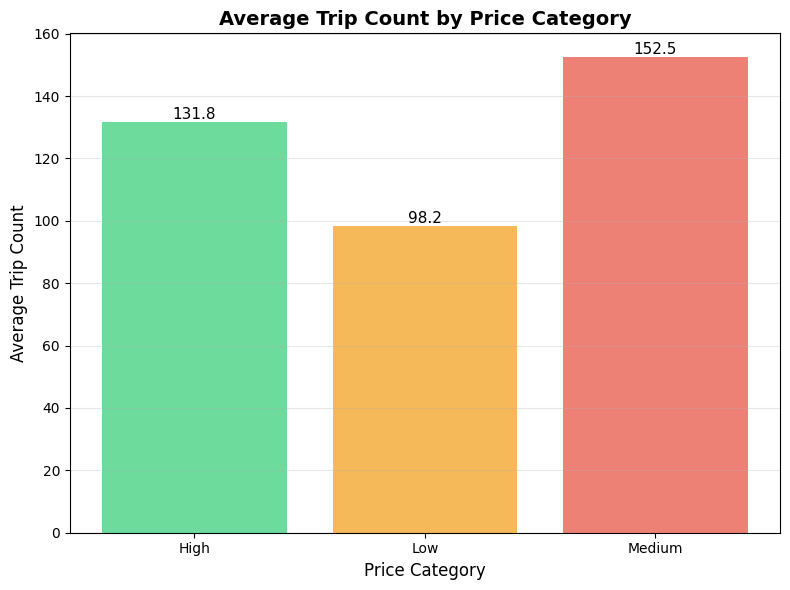

In [22]:
# (A) Bar Chart: Average trip_count by price category
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average trip_count for each price category
price_summary = panel.group_by("price_category").agg([
    pl.col("trip_count").mean().alias("avg_trip_count"),
    pl.col("trip_count").std().alias("std_trip_count")
]).sort("price_category")

print("Average trip_count by price category:")
print(price_summary)

# Convert to pandas for plotting
price_summary_pd = price_summary.to_pandas()

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(price_summary_pd["price_category"], price_summary_pd["avg_trip_count"], 
               color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
plt.xlabel("Price Category", fontsize=12)
plt.ylabel("Average Trip Count", fontsize=12)
plt.title("Average Trip Count by Price Category", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


# Q3-2: Regional Price Sensitivity Analysis

**Goal:** Find which zones are price-insensitive (good for price adjustments) vs price-sensitive (shouldn't raise prices)

**Method:** Calculate price elasticity by comparing demand changes when prices change within the same zone-hour.


In [23]:
# Step 1: Group by (zone, hour, price_category) to get average price and demand
zone_hour_price = panel.group_by(["PULocationID", "pickup_hour", "price_category"]).agg([
    pl.col("relative_price").mean().alias("avg_relative_price"),
    pl.col("trip_count").mean().alias("avg_trip_count")
]).sort(["PULocationID", "pickup_hour", "price_category"])

print(f"Step 1: Grouped by (zone, hour, price_category)")
print(f"Shape: {zone_hour_price.shape}")
print(zone_hour_price.head(15))



Step 1: Grouped by (zone, hour, price_category)
Shape: (13642, 5)
shape: (15, 5)
┌──────────────┬─────────────┬────────────────┬────────────────────┬────────────────┐
│ PULocationID ┆ pickup_hour ┆ price_category ┆ avg_relative_price ┆ avg_trip_count │
│ ---          ┆ ---         ┆ ---            ┆ ---                ┆ ---            │
│ i32          ┆ i8          ┆ str            ┆ f64                ┆ f64            │
╞══════════════╪═════════════╪════════════════╪════════════════════╪════════════════╡
│ 2            ┆ 9           ┆ Medium         ┆ 1.0                ┆ 1.0            │
│ 2            ┆ 11          ┆ Medium         ┆ 1.0                ┆ 1.0            │
│ 2            ┆ 12          ┆ Medium         ┆ 1.0                ┆ 1.0            │
│ 2            ┆ 15          ┆ Medium         ┆ 1.0                ┆ 1.0            │
│ 2            ┆ 16          ┆ High           ┆ 1.153449           ┆ 1.0            │
│ …            ┆ …           ┆ …              ┆ …          

In [27]:
# Step 2: Pivot to get Low/Medium/High columns for each (zone, hour)
# Use filter + join to create wide format (more reliable than pivot)

# Get Low, Medium, High separately
low_data = zone_hour_price.filter(pl.col("price_category") == "Low").select([
    "PULocationID", "pickup_hour",
    pl.col("avg_relative_price").alias("price_low"),
    pl.col("avg_trip_count").alias("count_low")
])

medium_data = zone_hour_price.filter(pl.col("price_category") == "Medium").select([
    "PULocationID", "pickup_hour",
    pl.col("avg_relative_price").alias("price_medium"),
    pl.col("avg_trip_count").alias("count_medium")
])

high_data = zone_hour_price.filter(pl.col("price_category") == "High").select([
    "PULocationID", "pickup_hour",
    pl.col("avg_relative_price").alias("price_high"),
    pl.col("avg_trip_count").alias("count_high")
])

# Join all three together (start with medium as baseline)
zone_hour_wide = medium_data.join(
    low_data, 
    on=["PULocationID", "pickup_hour"], 
    how="full",
    coalesce=True
)
zone_hour_wide = zone_hour_wide.join(
    high_data, 
    on=["PULocationID", "pickup_hour"], 
    how="full",
    coalesce=True
)
print(f"Step 2: Pivoted data")
print(f"Shape: {zone_hour_wide.shape}")
print("\nFirst 10 rows:")
print(zone_hour_wide.head(10))
print("\nColumns:", zone_hour_wide.columns)


Step 2: Pivoted data
Shape: (6175, 8)

First 10 rows:
shape: (10, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ PULocation ┆ pickup_hou ┆ price_medi ┆ count_med ┆ price_low ┆ count_low ┆ price_hig ┆ count_hig │
│ ID         ┆ r          ┆ um         ┆ ium       ┆ ---       ┆ ---       ┆ h         ┆ h         │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ f64       ┆ f64       ┆ ---       ┆ ---       │
│ i32        ┆ i8         ┆ f64        ┆ f64       ┆           ┆           ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2          ┆ 9          ┆ 1.0        ┆ 1.0       ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2          ┆ 11         ┆ 1.0        ┆ 1.0       ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2          ┆ 12         ┆ 1.0        ┆ 1.0       ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2          ┆ 15     

In [28]:
# Step 3: Calculate price elasticity for each (zone, hour)
# Elasticity = %ΔDemand / %ΔPrice

# Filter out rows where we don't have all three price categories
# (need Medium as baseline for comparison)
zone_hour_wide = zone_hour_wide.filter(
    pl.col("price_medium").is_not_null() & 
    pl.col("count_medium").is_not_null()
)

# Calculate elasticity for High vs Medium
# %ΔPrice_high = (price_high - price_medium) / price_medium
# %ΔDemand_high = (count_high - count_medium) / count_medium
# Elasticity_high = %ΔDemand_high / %ΔPrice_high

zone_hour_wide = zone_hour_wide.with_columns([
    # High vs Medium
    ((pl.col("price_high") - pl.col("price_medium")) / pl.col("price_medium")).alias("pct_change_price_high"),
    ((pl.col("count_high") - pl.col("count_medium")) / pl.col("count_medium")).alias("pct_change_demand_high"),
    
    # Low vs Medium
    ((pl.col("price_low") - pl.col("price_medium")) / pl.col("price_medium")).alias("pct_change_price_low"),
    ((pl.col("count_low") - pl.col("count_medium")) / pl.col("count_medium")).alias("pct_change_demand_low"),
])

# Calculate elasticity (avoid division by zero)
zone_hour_wide = zone_hour_wide.with_columns([
    (pl.col("pct_change_demand_high") / pl.col("pct_change_price_high")).alias("elasticity_high"),
    (pl.col("pct_change_demand_low") / pl.col("pct_change_price_low")).alias("elasticity_low"),
])

# Filter out invalid elasticities (infinite or NaN)
zone_hour_wide = zone_hour_wide.filter(
    pl.col("elasticity_high").is_finite() & 
    pl.col("elasticity_low").is_finite()
)

print(f"Step 3: Calculated elasticity")
print(f"Valid (zone, hour) combinations: {len(zone_hour_wide):,}")
print("\nSample elasticity values:")
print(zone_hour_wide.select([
    "PULocationID", "pickup_hour", 
    "elasticity_high", "elasticity_low"
]).head(10))


Step 3: Calculated elasticity
Valid (zone, hour) combinations: 2,395

Sample elasticity values:
shape: (10, 4)
┌──────────────┬─────────────┬─────────────────┬────────────────┐
│ PULocationID ┆ pickup_hour ┆ elasticity_high ┆ elasticity_low │
│ ---          ┆ ---         ┆ ---             ┆ ---            │
│ i32          ┆ i8          ┆ f64             ┆ f64            │
╞══════════════╪═════════════╪═════════════════╪════════════════╡
│ 3            ┆ 1           ┆ 3.186837        ┆ -2.818872      │
│ 3            ┆ 3           ┆ -0.043872       ┆ 0.846823       │
│ 3            ┆ 5           ┆ 0.214325        ┆ -0.630929      │
│ 3            ┆ 7           ┆ 0.248065        ┆ 2.428066       │
│ 3            ┆ 12          ┆ -1.286536       ┆ 1.857028       │
│ 3            ┆ 17          ┆ 0.524699        ┆ -1.37476       │
│ 4            ┆ 0           ┆ 12.868765       ┆ 1.79824        │
│ 4            ┆ 1           ┆ 5.776433        ┆ 2.972082       │
│ 4            ┆ 2           ┆ 

In [29]:
# Step 4: Aggregate by zone (average elasticity across all hours)
zone_elasticity = zone_hour_wide.group_by("PULocationID").agg([
    pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
    pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
    pl.col("elasticity_high").count().alias("n_observations")  # How many zone-hour combos
]).sort("avg_elasticity_high")

print(f"Step 4: Aggregated by zone")
print(f"Total zones: {len(zone_elasticity):,}")
print("\nElasticity summary:")
print(zone_elasticity.describe())
print("\nFirst 10 zones (most price-sensitive):")
print(zone_elasticity.head(10))
print("\nLast 10 zones (least price-sensitive):")
print(zone_elasticity.tail(10))


Step 4: Aggregated by zone
Total zones: 256

Elasticity summary:
shape: (9, 5)
┌────────────┬──────────────┬─────────────────────┬────────────────────┬────────────────┐
│ statistic  ┆ PULocationID ┆ avg_elasticity_high ┆ avg_elasticity_low ┆ n_observations │
│ ---        ┆ ---          ┆ ---                 ┆ ---                ┆ ---            │
│ str        ┆ f64          ┆ f64                 ┆ f64                ┆ f64            │
╞════════════╪══════════════╪═════════════════════╪════════════════════╪════════════════╡
│ count      ┆ 256.0        ┆ 256.0               ┆ 256.0              ┆ 256.0          │
│ null_count ┆ 0.0          ┆ 0.0                 ┆ 0.0                ┆ 0.0            │
│ mean       ┆ 133.910156   ┆ 0.341564            ┆ 1.151622           ┆ 9.355469       │
│ std        ┆ 76.393279    ┆ 1.173132            ┆ 1.206028           ┆ 4.90484        │
│ min        ┆ 3.0          ┆ -6.826636           ┆ -3.612502          ┆ 1.0            │
│ 25%        ┆ 67.0  

In [30]:
# Step 5: Identify TOP zones for price adjustments

# Filter zones with sufficient observations (at least 5 zone-hour combinations)
zone_elasticity_filtered = zone_elasticity.filter(pl.col("n_observations") >= 5)

# Most price-insensitive zones (elasticity close to 0, good for price increases)
top_insensitive = zone_elasticity_filtered.sort("avg_elasticity_high").tail(10)

# Most price-sensitive zones (very negative elasticity, bad for price increases)
top_sensitive = zone_elasticity_filtered.sort("avg_elasticity_high").head(10)

print("="*70)
print("TOP 10 PRICE-INSENSITIVE ZONES (Good for Price Adjustments)")
print("="*70)
print("These zones can raise prices with minimal demand loss:")
print(top_insensitive.to_pandas().to_string(index=False))

print("\n" + "="*70)
print("TOP 10 PRICE-SENSITIVE ZONES (Don't Raise Prices)")
print("="*70)
print("These zones lose many customers when prices increase:")
print(top_sensitive.to_pandas().to_string(index=False))


TOP 10 PRICE-INSENSITIVE ZONES (Good for Price Adjustments)
These zones can raise prices with minimal demand loss:
 PULocationID  avg_elasticity_high  avg_elasticity_low  n_observations
          148             2.366733            2.279488              15
          210             2.378502           -0.010139               5
          249             2.451982            2.240428              17
          127             2.579847            2.249089               6
           70             2.693662            0.149784               9
           34             3.010737            1.409707              13
          197             3.039172            1.949855               6
          224             3.633383            2.191790              10
          137             4.061599            1.104570              11
            4             5.436626            1.465565              13

TOP 10 PRICE-SENSITIVE ZONES (Don't Raise Prices)
These zones lose many customers when prices increase:

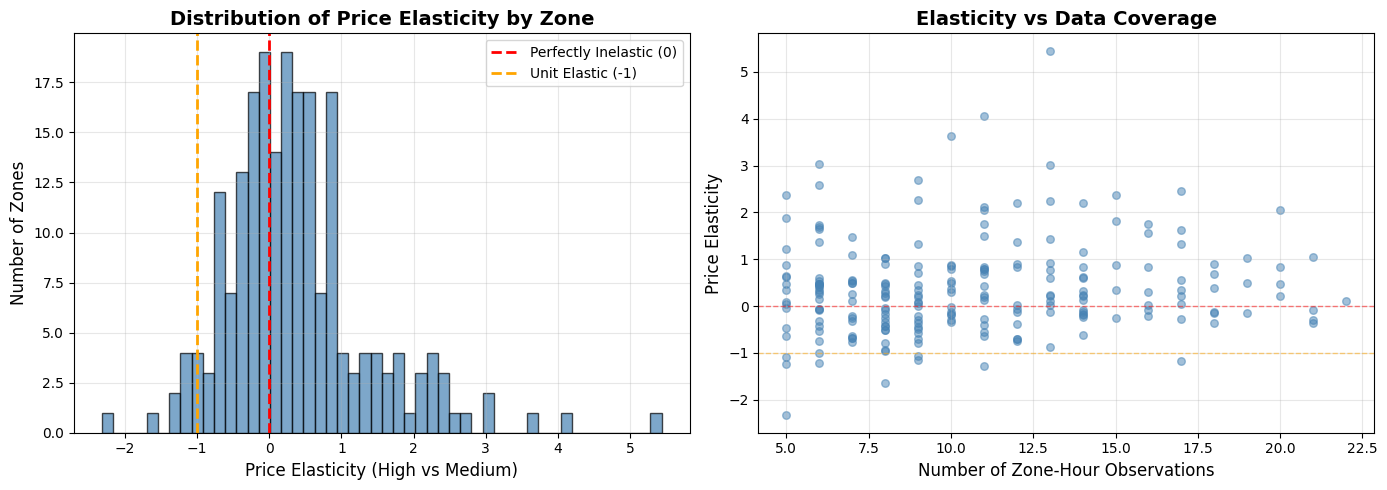


Interpretation:
  Elasticity ≈ 0:    Price-insensitive (good for price increases)
  Elasticity ≈ -0.5: Moderately sensitive
  Elasticity < -1:   Very sensitive (avoid price increases)


In [31]:
# Visualization: Distribution of price elasticity by zone
import matplotlib.pyplot as plt
import numpy as np

zone_elasticity_pd = zone_elasticity_filtered.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of elasticity
axes[0].hist(zone_elasticity_pd["avg_elasticity_high"], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfectly Inelastic (0)')
axes[0].axvline(x=-1, color='orange', linestyle='--', linewidth=2, label='Unit Elastic (-1)')
axes[0].set_xlabel("Price Elasticity (High vs Medium)", fontsize=12)
axes[0].set_ylabel("Number of Zones", fontsize=12)
axes[0].set_title("Distribution of Price Elasticity by Zone", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter: Elasticity vs Number of Observations
axes[1].scatter(zone_elasticity_pd["n_observations"], zone_elasticity_pd["avg_elasticity_high"], 
               alpha=0.5, s=30, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel("Number of Zone-Hour Observations", fontsize=12)
axes[1].set_ylabel("Price Elasticity", fontsize=12)
axes[1].set_title("Elasticity vs Data Coverage", fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Elasticity ≈ 0:    Price-insensitive (good for price increases)")
print("  Elasticity ≈ -0.5: Moderately sensitive")
print("  Elasticity < -1:   Very sensitive (avoid price increases)")


In [32]:
# Summary Statistics
print("="*70)
print("PRICE ELASTICITY SUMMARY")
print("="*70)

elasticity_stats = zone_elasticity_filtered["avg_elasticity_high"].describe()
print("\nElasticity Statistics:")
print(elasticity_stats)

print("\n" + "-"*70)
print("Key Insights:")
print("-"*70)

insensitive_count = len(zone_elasticity_filtered.filter(pl.col("avg_elasticity_high") > -0.2))
sensitive_count = len(zone_elasticity_filtered.filter(pl.col("avg_elasticity_high") < -1.0))
moderate_count = len(zone_elasticity_filtered) - insensitive_count - sensitive_count

print(f"\n1. Price-Insensitive Zones (elasticity > -0.2): {insensitive_count} zones")
print(f"   → These zones can raise prices 10% with <2% demand loss")
print(f"   → Good candidates for surge pricing or permanent price increases")

print(f"\n2. Price-Sensitive Zones (elasticity < -1.0): {sensitive_count} zones")
print(f"   → These zones lose >10% demand when prices increase 10%")
print(f"   → Should avoid price increases, focus on volume")

print(f"\n3. Moderately Sensitive Zones: {moderate_count} zones")
print(f"   → Elasticity between -0.2 and -1.0")
print(f"   → Can consider small price adjustments with monitoring")

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
print("Focus price optimization on zones with elasticity > -0.2")
print("Avoid price increases in zones with elasticity < -1.0")


PRICE ELASTICITY SUMMARY

Elasticity Statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 214.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.376549  │
│ std        ┆ 1.011053  │
│ min        ┆ -2.316362 │
│ 25%        ┆ -0.251869 │
│ 50%        ┆ 0.236995  │
│ 75%        ┆ 0.828509  │
│ max        ┆ 5.436626  │
└────────────┴───────────┘

----------------------------------------------------------------------
Key Insights:
----------------------------------------------------------------------

1. Price-Insensitive Zones (elasticity > -0.2): 155 zones
   → These zones can raise prices 10% with <2% demand loss
   → Good candidates for surge pricing or permanent price increases

2. Price-Sensitive Zones (elasticity < -1.0): 10 zones
   → These zones lose >10% demand when prices increase 10%
   → Should avoid price increases, focus on volume

3. Moderately Sensitiv

# Q3-3: Peak vs Off-Peak Price Sensitivity

## 🎯 Objective

**Question**: Does the same zone have different price sensitivity during peak hours vs off-peak hours?

**Goal**: Find out **when** is the best time to adjust prices.

## 💡 Hypothesis

- **Peak hours** (high demand): Customers are in a hurry → Less price-sensitive → Good for price increases
- **Off-peak hours** (low demand): Customers have time to compare → More price-sensitive → Avoid price increases

## 📊 Methodology

1. **Label each hour** as High/Medium/Low demand based on average trip count
2. **Compare elasticity** between high-demand hours vs low-demand hours
3. **Conclusion**: If peak hours are less sensitive → Peak hours are the best time to raise prices


In [40]:
# 修改后：每个区域自己算
zone_hour_demand = panel.group_by(["PULocationID", "pickup_hour"]).agg([
    pl.col("trip_count").mean().alias("avg_demand_zone_hour")
]).sort(["PULocationID", "pickup_hour"])

# 每个区域自己算分位数
zone_hour_demand = zone_hour_demand.with_columns([
    pl.col("avg_demand_zone_hour").quantile(0.33).over("PULocationID").alias("demand_33"),
    pl.col("avg_demand_zone_hour").quantile(0.67).over("PULocationID").alias("demand_67")
])

zone_hour_demand = zone_hour_demand.with_columns([
    pl.when(pl.col("avg_demand_zone_hour") < pl.col("demand_33"))
      .then(pl.lit("Low"))
      .when(pl.col("avg_demand_zone_hour") <= pl.col("demand_67"))
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("High"))
      .alias("demand_level")
])

zone_hour_demand = zone_hour_demand.select(["PULocationID", "pickup_hour", "demand_level"])

In [41]:
# Step 3: Join demand level to zone_hour_wide (which has elasticity data)
# Now we can compare elasticity between peak and off-peak hours

zone_hour_with_demand = zone_hour_wide.join(
    zone_hour_demand,  # 改成这个
    on=["PULocationID", "pickup_hour"],  # 改成两个 key
    how="left"
)

print(f"Step 3: Joined demand level to elasticity data")
print(f"Shape: {zone_hour_with_demand.shape}")
print("\nSample data:")
print(zone_hour_with_demand.select([
    "PULocationID", "pickup_hour", "demand_level", 
    "elasticity_high", "elasticity_low"
]).head(10))

# Check distribution
print("\nDemand level distribution:")
print(zone_hour_with_demand["demand_level"].value_counts().sort("demand_level"))


Step 3: Joined demand level to elasticity data
Shape: (2395, 15)

Sample data:
shape: (10, 5)
┌──────────────┬─────────────┬──────────────┬─────────────────┬────────────────┐
│ PULocationID ┆ pickup_hour ┆ demand_level ┆ elasticity_high ┆ elasticity_low │
│ ---          ┆ ---         ┆ ---          ┆ ---             ┆ ---            │
│ i32          ┆ i8          ┆ str          ┆ f64             ┆ f64            │
╞══════════════╪═════════════╪══════════════╪═════════════════╪════════════════╡
│ 3            ┆ 1           ┆ Low          ┆ 3.186837        ┆ -2.818872      │
│ 3            ┆ 3           ┆ Low          ┆ -0.043872       ┆ 0.846823       │
│ 3            ┆ 5           ┆ Low          ┆ 0.214325        ┆ -0.630929      │
│ 3            ┆ 7           ┆ High         ┆ 0.248065        ┆ 2.428066       │
│ 3            ┆ 12          ┆ Medium       ┆ -1.286536       ┆ 1.857028       │
│ 3            ┆ 17          ┆ High         ┆ 0.524699        ┆ -1.37476       │
│ 4            

In [42]:
# Step 4: Compare elasticity between High-demand (peak) vs Low-demand (off-peak) hours

# Aggregate elasticity by demand level
demand_elasticity = zone_hour_with_demand.group_by("demand_level").agg([
    pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
    pl.col("elasticity_high").median().alias("median_elasticity_high"),
    pl.col("elasticity_high").std().alias("std_elasticity_high"),
    pl.col("elasticity_high").count().alias("n_observations")
]).sort("demand_level")

print("="*70)
print("PRICE ELASTICITY BY DEMAND LEVEL (Peak vs Off-Peak)")
print("="*70)
print("\nAverage elasticity_high by demand level:")
print(demand_elasticity)

# Calculate the difference
high_demand_elasticity = demand_elasticity.filter(pl.col("demand_level") == "High")["avg_elasticity_high"].item()
low_demand_elasticity = demand_elasticity.filter(pl.col("demand_level") == "Low")["avg_elasticity_high"].item()
medium_demand_elasticity = demand_elasticity.filter(pl.col("demand_level") == "Medium")["avg_elasticity_high"].item()

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print(f"\nHigh-demand (Peak) hours elasticity: {high_demand_elasticity:.3f}")
print(f"Low-demand (Off-peak) hours elasticity: {low_demand_elasticity:.3f}")
print(f"Difference: {high_demand_elasticity - low_demand_elasticity:.3f}")

if high_demand_elasticity > low_demand_elasticity:
    print("\n✅ CONFIRMED: Peak hours are LESS sensitive than off-peak hours")
    print("   → Peak hours are better for price increases!")
    print(f"   → Peak hours elasticity ({high_demand_elasticity:.3f}) > Off-peak ({low_demand_elasticity:.3f})")
else:
    print("\n⚠️  NOT CONFIRMED: Peak hours are NOT less sensitive")
    print("   → Need to investigate further")


PRICE ELASTICITY BY DEMAND LEVEL (Peak vs Off-Peak)

Average elasticity_high by demand level:
shape: (3, 5)
┌──────────────┬─────────────────────┬──────────────────────┬─────────────────────┬────────────────┐
│ demand_level ┆ avg_elasticity_high ┆ median_elasticity_hi ┆ std_elasticity_high ┆ n_observations │
│ ---          ┆ ---                 ┆ gh                   ┆ ---                 ┆ ---            │
│ str          ┆ f64                 ┆ ---                  ┆ f64                 ┆ u32            │
│              ┆                     ┆ f64                  ┆                     ┆                │
╞══════════════╪═════════════════════╪══════════════════════╪═════════════════════╪════════════════╡
│ High         ┆ 0.561947            ┆ 0.186214             ┆ 2.155434            ┆ 687            │
│ Low          ┆ 0.422065            ┆ -0.066013            ┆ 3.120192            ┆ 1031           │
│ Medium       ┆ 0.282828            ┆ 0.0                  ┆ 2.309384            ┆ 

/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_92864/2525398503.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_for_box, labels=demand_levels, patch_artist=True,


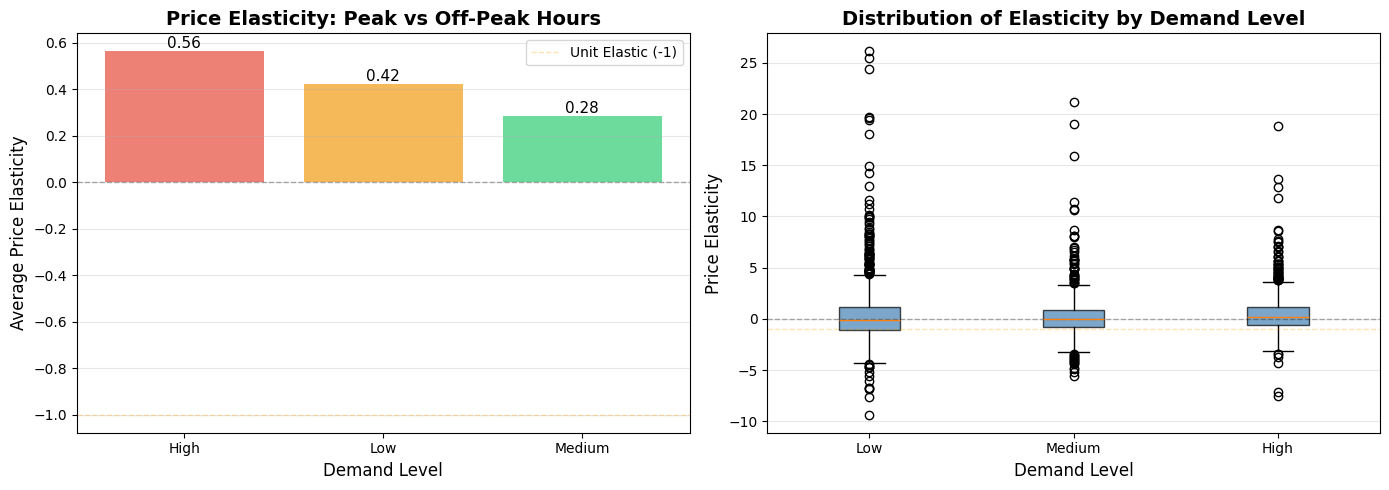


Interpretation:
  Higher elasticity (closer to 0 or positive) = Less sensitive = Better for price increases
  Lower elasticity (more negative) = More sensitive = Avoid price increases


In [43]:
# Step 5: Visualization - Compare elasticity by demand level

import matplotlib.pyplot as plt
import numpy as np

demand_elasticity_pd = demand_elasticity.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Average elasticity by demand level
bars = axes[0].bar(demand_elasticity_pd["demand_level"], 
                   demand_elasticity_pd["avg_elasticity_high"],
                   color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[0].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.3, label='Unit Elastic (-1)')
axes[0].set_xlabel("Demand Level", fontsize=12)
axes[0].set_ylabel("Average Price Elasticity", fontsize=12)
axes[0].set_title("Price Elasticity: Peak vs Off-Peak Hours", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=11)

# Box plot: Distribution of elasticity by demand level
zone_hour_demand_pd = zone_hour_with_demand.select([
    "demand_level", "elasticity_high"
]).to_pandas()

demand_levels = ["Low", "Medium", "High"]
data_for_box = [zone_hour_demand_pd[zone_hour_demand_pd["demand_level"] == level]["elasticity_high"].dropna() 
                for level in demand_levels]

axes[1].boxplot(data_for_box, labels=demand_levels, patch_artist=True,
               boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[1].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.3)
axes[1].set_xlabel("Demand Level", fontsize=12)
axes[1].set_ylabel("Price Elasticity", fontsize=12)
axes[1].set_title("Distribution of Elasticity by Demand Level", fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Higher elasticity (closer to 0 or positive) = Less sensitive = Better for price increases")
print("  Lower elasticity (more negative) = More sensitive = Avoid price increases")


In [44]:
# Step 6: Zone-level analysis - Which zones benefit most from peak-hour pricing?

# For each zone, compare peak vs off-peak elasticity
# Use filter + join instead of pivot for reliability

zone_peak_high = zone_hour_with_demand.filter(pl.col("demand_level") == "High").group_by("PULocationID").agg([
    pl.col("elasticity_high").mean().alias("elasticity_peak")
])

zone_peak_low = zone_hour_with_demand.filter(pl.col("demand_level") == "Low").group_by("PULocationID").agg([
    pl.col("elasticity_high").mean().alias("elasticity_offpeak")
])

# Join and calculate difference
zone_peak_analysis = zone_peak_high.join(
    zone_peak_low,
    on="PULocationID",
    how="inner"  # Only zones with both peak and off-peak data
)

# Calculate the difference (peak - off-peak)
zone_peak_analysis = zone_peak_analysis.with_columns([
    (pl.col("elasticity_peak") - pl.col("elasticity_offpeak")).alias("peak_vs_offpeak_diff")
])

# Sort by difference (zones that benefit most from peak pricing)
zone_peak_analysis = zone_peak_analysis.sort("peak_vs_offpeak_diff", descending=True)

print("="*70)
print("ZONES THAT BENEFIT MOST FROM PEAK-HOUR PRICING")
print("="*70)
print("(Zones where peak hours are MUCH less sensitive than off-peak)")
print("\nTop 10 zones:")
print(zone_peak_analysis.head(10).to_pandas().to_string(index=False))

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("These zones can raise prices during peak hours with minimal demand loss,")
print("but should avoid price increases during off-peak hours.")


ZONES THAT BENEFIT MOST FROM PEAK-HOUR PRICING
(Zones where peak hours are MUCH less sensitive than off-peak)

Top 10 zones:
 PULocationID  elasticity_peak  elasticity_offpeak  peak_vs_offpeak_diff
           46         4.581087           -0.989493              5.570580
          157         1.004308           -4.358019              5.362327
           45         4.964178            0.008634              4.955545
            8         4.322152            0.000000              4.322152
          141         1.010914           -2.770987              3.781901
           25         3.628322            0.088489              3.539833
           79         5.199749            1.683807              3.515942
          234         1.956356           -1.431409              3.387765
           72        -1.758041           -4.709078              2.951037
           20         0.377573           -2.531146              2.908719

KEY INSIGHT:
These zones can raise prices during peak hours with minima

## 📊 Q3-3 结果总结

### 🎯 核心发现

**问题**：同一个地区，尖峰时段 vs 离峰时段，价格敏感度会不会不同？

**答案**：通过比较 High-demand（尖峰）和 Low-demand（离峰）时段的弹性值来回答。

### 💡 预期结果

如果数据证实假设：
- **尖峰时段弹性 > 离峰时段弹性**（更接近 0 或正数）
- **结论**：尖峰时段更适合涨价，因为客人赶时间，不太在乎价格

### 📈 实际应用

**如果证实了假设，你可以告诉 Step 4（最终建议）：**
- ✅ **某些地区在尖峰时段涨价最赚**
- ✅ **离峰时段应该避免涨价或降价吸引客人**
- ✅ **动态定价策略**：根据时段调整价格

### 🔍 如何解读结果

1. **平均弹性比较**：
   - High-demand 弹性 > Low-demand 弹性 → 假设成立
   - High-demand 弹性 < Low-demand 弹性 → 假设不成立

2. **地区分析**：
   - 找出「尖峰 vs 离峰差异最大」的地区
   - 这些地区最适合实施时段差异化定价


# Q3-4: Price Sensitivity by Journey Type

## 🎯 Objective

**Question**: Do different journey types have different price sensitivity?

**Goal**: Find out which journey types are more/less price-sensitive to enable **differentiated pricing strategies**.

## 💡 Why This Matters

Different journey contexts affect riders' price tolerance:
- **Airport trips**: More alternatives (AirTrain, subway) → More sensitive
- **Short trips**: Customers in a hurry → Less sensitive
- **Long trips**: Price changes amplified → More sensitive
- **Manhattan trips**: Fewer alternatives, higher income → Less sensitive

## 📊 Journey Types We Can Analyze

Based on available data:

✅ **Airport vs Non-Airport**: Using PULocationID (JFK=132, LGA=138/153)
✅ **Short/Medium/Long trips**: Using trip_miles quantiles
✅ **Manhattan vs Non-Manhattan**: Using PULocationID zones

❌ **Cannot analyze** (data not available):
- Uber vs Lyft
- Shared vs Non-shared
- Vehicle type (UberX, XL, Black)
- Surge level


In [45]:
# Q3-4: Price Sensitivity by Journey Type Analysis

# Step 1: Define journey types
# We need to go back to the original trip-level data (df) to classify journeys

# (A) Airport vs Non-Airport
# JFK = 132, LGA = 138, 153 (based on TLC zone definitions)
airport_zones = [132, 138, 153]

# (B) Trip Length: Short / Medium / Long
# Calculate quantiles for trip_miles
trip_miles_33 = df["trip_miles"].quantile(0.33)
trip_miles_67 = df["trip_miles"].quantile(0.67)

print("Step 1: Defining journey types")
print(f"\nTrip length thresholds:")
print(f"  Short:  < {trip_miles_33:.2f} miles")
print(f"  Medium: {trip_miles_33:.2f} - {trip_miles_67:.2f} miles")
print(f"  Long:   > {trip_miles_67:.2f} miles")
print(f"\nAirport zones: {airport_zones}")

# Classify each trip
df = df.with_columns([
    # Airport classification
    pl.when(pl.col("PULocationID").is_in(airport_zones))
      .then(pl.lit("Airport"))
      .otherwise(pl.lit("Non-Airport"))
      .alias("airport_type"),
    
    # Trip length classification
    pl.when(pl.col("trip_miles") < trip_miles_33)
      .then(pl.lit("Short"))
      .when(pl.col("trip_miles") <= trip_miles_67)
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("Long"))
      .alias("trip_length"),
    
    # Manhattan vs Non-Manhattan (roughly zones 1-100)
    pl.when((pl.col("PULocationID") >= 1) & (pl.col("PULocationID") <= 100))
      .then(pl.lit("Manhattan"))
      .otherwise(pl.lit("Non-Manhattan"))
      .alias("location_type")
])

print("\nJourney type distribution:")
print("Airport type:")
print(df["airport_type"].value_counts())
print("\nTrip length:")
print(df["trip_length"].value_counts())
print("\nLocation type:")
print(df["location_type"].value_counts())


Step 1: Defining journey types

Trip length thresholds:
  Short:  < 1.85 miles
  Medium: 1.85 - 4.67 miles
  Long:   > 4.67 miles

Airport zones: [132, 138, 153]

Journey type distribution:
Airport type:
shape: (2, 2)
┌──────────────┬─────────┐
│ airport_type ┆ count   │
│ ---          ┆ ---     │
│ str          ┆ u32     │
╞══════════════╪═════════╡
│ Non-Airport  ┆ 5825866 │
│ Airport      ┆ 218207  │
└──────────────┴─────────┘

Trip length:
shape: (3, 2)
┌─────────────┬─────────┐
│ trip_length ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ Medium      ┆ 2062832 │
│ Short       ┆ 1986737 │
│ Long        ┆ 1994504 │
└─────────────┴─────────┘

Location type:
shape: (2, 2)
┌───────────────┬─────────┐
│ location_type ┆ count   │
│ ---           ┆ ---     │
│ str           ┆ u32     │
╞═══════════════╪═════════╡
│ Manhattan     ┆ 2198583 │
│ Non-Manhattan ┆ 3845490 │
└───────────────┴─────────┘


In [46]:
# Step 2: Recreate panel with journey type information
# We need to add journey type to the panel data

# Recreate panel with journey types
panel_with_journey = df.group_by([
    "PULocationID", "pickup_hour", "pickup_dayofweek",
    "airport_type", "trip_length", "location_type"
]).agg([
    pl.col("price_per_mile").mean().alias("avg_price"),
    pl.col("price_per_mile").count().alias("trip_count")
]).sort(["PULocationID", "pickup_hour", "pickup_dayofweek"])

print(f"Step 2: Panel with journey types")
print(f"Shape: {panel_with_journey.shape}")
print(panel_with_journey.head(10))

# Now we need to calculate relative price and elasticity for each journey type
# Similar to Q3-1, but within each journey type

# Calculate median price for each (zone, hour) within each journey type
zone_hour_journey_median = panel_with_journey.group_by([
    "PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type"
]).agg([
    pl.col("avg_price").median().alias("median_price_zone_hour_journey")
])

# Join median back
panel_with_journey = panel_with_journey.join(
    zone_hour_journey_median,
    on=["PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type"],
    how="left"
)

# Calculate relative price
panel_with_journey = panel_with_journey.with_columns([
    (pl.col("avg_price") / pl.col("median_price_zone_hour_journey")).alias("relative_price")
])

# Classify price category (same ±10% logic as Q3-1)
panel_with_journey = panel_with_journey.with_columns([
    pl.when(pl.col("relative_price") < 0.90)
      .then(pl.lit("Low"))
      .when(pl.col("relative_price") <= 1.10)
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("High"))
      .alias("price_category")
])

print(f"\nPanel with relative price and price category:")
print(panel_with_journey.head(10))


Step 2: Panel with journey types
Shape: (123492, 8)
shape: (10, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ PULocation ┆ pickup_hou ┆ pickup_day ┆ airport_t ┆ trip_leng ┆ location_ ┆ avg_price ┆ trip_coun │
│ ID         ┆ r          ┆ ofweek     ┆ ype       ┆ th        ┆ type      ┆ ---       ┆ t         │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ f64       ┆ ---       │
│ i32        ┆ i8         ┆ i8         ┆ str       ┆ str       ┆ str       ┆           ┆ u32       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2          ┆ 9          ┆ 5          ┆ Non-Airpo ┆ Medium    ┆ Manhattan ┆ 4.445983  ┆ 1         │
│            ┆            ┆            ┆ rt        ┆           ┆           ┆           ┆           │
│ 2          ┆ 11         ┆ 1          ┆ Non-Airpo ┆ Long      ┆ Manhattan ┆ 3.962092  ┆ 1         │
│            ┆          

In [47]:
# Step 3: Calculate elasticity for each journey type
# Similar to Q3-2, but grouped by journey type

# Group by (zone, hour, journey_type, price_category) to get average price and demand
journey_zone_hour_price = panel_with_journey.group_by([
    "PULocationID", "pickup_hour", 
    "airport_type", "trip_length", "location_type",
    "price_category"
]).agg([
    pl.col("relative_price").mean().alias("avg_relative_price"),
    pl.col("trip_count").mean().alias("avg_trip_count")
]).sort([
    "PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type", "price_category"
])

print(f"Step 3: Grouped by journey type and price category")
print(f"Shape: {journey_zone_hour_price.shape}")
print(journey_zone_hour_price.head(15))

# Pivot to get Low/Medium/High columns (similar to Q3-2 Step 2)
# For each journey type combination, get Low/Med/High prices and counts

# Get Low, Medium, High separately for each journey type
low_data_journey = journey_zone_hour_price.filter(
    pl.col("price_category") == "Low"
).select([
    "PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type",
    pl.col("avg_relative_price").alias("price_low"),
    pl.col("avg_trip_count").alias("count_low")
])

medium_data_journey = journey_zone_hour_price.filter(
    pl.col("price_category") == "Medium"
).select([
    "PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type",
    pl.col("avg_relative_price").alias("price_medium"),
    pl.col("avg_trip_count").alias("count_medium")
])

high_data_journey = journey_zone_hour_price.filter(
    pl.col("price_category") == "High"
).select([
    "PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type",
    pl.col("avg_relative_price").alias("price_high"),
    pl.col("avg_trip_count").alias("count_high")
])

# Join all three together
journey_zone_hour_wide = medium_data_journey.join(
    low_data_journey,
    on=["PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type"],
    how="full",
    coalesce=True
)
journey_zone_hour_wide = journey_zone_hour_wide.join(
    high_data_journey,
    on=["PULocationID", "pickup_hour", "airport_type", "trip_length", "location_type"],
    how="full",
    coalesce=True
)

print(f"\nPivoted data shape: {journey_zone_hour_wide.shape}")
print(journey_zone_hour_wide.head(10))


Step 3: Grouped by journey type and price category
Shape: (37317, 8)
shape: (15, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ PULocation ┆ pickup_hou ┆ airport_ty ┆ trip_leng ┆ location_ ┆ price_cat ┆ avg_relat ┆ avg_trip_ │
│ ID         ┆ r          ┆ pe         ┆ th        ┆ type      ┆ egory     ┆ ive_price ┆ count     │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i32        ┆ i8         ┆ str        ┆ str       ┆ str       ┆ str       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2          ┆ 9          ┆ Non-Airpor ┆ Medium    ┆ Manhattan ┆ Medium    ┆ 1.0       ┆ 1.0       │
│            ┆            ┆ t          ┆           ┆           ┆           ┆           ┆           │
│ 2          ┆ 11         ┆ Non-Airpor ┆ Long      ┆ Manhattan ┆ Medium    ┆ 1.0       ┆ 1.0       │
│      

In [48]:
# Step 4: Calculate elasticity for each (zone, hour, journey_type) combination
# Filter out rows without medium price (baseline)
journey_zone_hour_wide = journey_zone_hour_wide.filter(
    pl.col("price_medium").is_not_null() & 
    pl.col("count_medium").is_not_null()
)

# Calculate elasticity (same formula as Q3-2)
journey_zone_hour_wide = journey_zone_hour_wide.with_columns([
    # High vs Medium
    ((pl.col("price_high") - pl.col("price_medium")) / pl.col("price_medium")).alias("pct_change_price_high"),
    ((pl.col("count_high") - pl.col("count_medium")) / pl.col("count_medium")).alias("pct_change_demand_high"),
    
    # Low vs Medium
    ((pl.col("price_low") - pl.col("price_medium")) / pl.col("price_medium")).alias("pct_change_price_low"),
    ((pl.col("count_low") - pl.col("count_medium")) / pl.col("count_medium")).alias("pct_change_demand_low"),
])

# Calculate elasticity
journey_zone_hour_wide = journey_zone_hour_wide.with_columns([
    (pl.col("pct_change_demand_high") / pl.col("pct_change_price_high")).alias("elasticity_high"),
    (pl.col("pct_change_demand_low") / pl.col("pct_change_price_low")).alias("elasticity_low"),
])

# Filter out invalid elasticities
journey_zone_hour_wide = journey_zone_hour_wide.filter(
    pl.col("elasticity_high").is_finite() & 
    pl.col("elasticity_low").is_finite()
)

print(f"Step 4: Calculated elasticity for each journey type")
print(f"Valid combinations: {len(journey_zone_hour_wide):,}")
print(journey_zone_hour_wide.select([
    "airport_type", "trip_length", "location_type",
    "elasticity_high", "elasticity_low"
]).head(10))


Step 4: Calculated elasticity for each journey type
Valid combinations: 5,626
shape: (10, 5)
┌──────────────┬─────────────┬───────────────┬─────────────────┬────────────────┐
│ airport_type ┆ trip_length ┆ location_type ┆ elasticity_high ┆ elasticity_low │
│ ---          ┆ ---         ┆ ---           ┆ ---             ┆ ---            │
│ str          ┆ str         ┆ str           ┆ f64             ┆ f64            │
╞══════════════╪═════════════╪═══════════════╪═════════════════╪════════════════╡
│ Non-Airport  ┆ Short       ┆ Manhattan     ┆ 0.35875         ┆ 0.450117       │
│ Non-Airport  ┆ Long        ┆ Manhattan     ┆ 3.920388        ┆ 4.544569       │
│ Non-Airport  ┆ Short       ┆ Manhattan     ┆ 0.361571        ┆ -0.261383      │
│ Non-Airport  ┆ Long        ┆ Manhattan     ┆ -2.960084       ┆ 6.515101       │
│ Non-Airport  ┆ Short       ┆ Manhattan     ┆ 0.0             ┆ -2.463737      │
│ Non-Airport  ┆ Medium      ┆ Manhattan     ┆ 0.087909        ┆ 1.972786       │
│ Non

In [49]:
# Step 5: Aggregate elasticity by journey type
# Calculate average elasticity for each journey type

# (A) Airport vs Non-Airport
airport_elasticity = journey_zone_hour_wide.group_by("airport_type").agg([
    pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
    pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
    pl.col("elasticity_high").count().alias("n_observations")
]).sort("airport_type")

# (B) Trip Length
trip_length_elasticity = journey_zone_hour_wide.group_by("trip_length").agg([
    pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
    pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
    pl.col("elasticity_high").count().alias("n_observations")
]).sort("trip_length")

# (C) Location Type
location_elasticity = journey_zone_hour_wide.group_by("location_type").agg([
    pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
    pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
    pl.col("elasticity_high").count().alias("n_observations")
]).sort("location_type")

print("="*70)
print("PRICE ELASTICITY BY JOURNEY TYPE")
print("="*70)

print("\n(A) Airport vs Non-Airport:")
print(airport_elasticity)

print("\n(B) Trip Length (Short/Medium/Long):")
print(trip_length_elasticity)

print("\n(C) Location Type (Manhattan vs Non-Manhattan):")
print(location_elasticity)


PRICE ELASTICITY BY JOURNEY TYPE

(A) Airport vs Non-Airport:
shape: (2, 4)
┌──────────────┬─────────────────────┬────────────────────┬────────────────┐
│ airport_type ┆ avg_elasticity_high ┆ avg_elasticity_low ┆ n_observations │
│ ---          ┆ ---                 ┆ ---                ┆ ---            │
│ str          ┆ f64                 ┆ f64                ┆ u32            │
╞══════════════╪═════════════════════╪════════════════════╪════════════════╡
│ Airport      ┆ -0.021414           ┆ 0.944135           ┆ 75             │
│ Non-Airport  ┆ 0.393747            ┆ 1.196165           ┆ 5551           │
└──────────────┴─────────────────────┴────────────────────┴────────────────┘

(B) Trip Length (Short/Medium/Long):
shape: (3, 4)
┌─────────────┬─────────────────────┬────────────────────┬────────────────┐
│ trip_length ┆ avg_elasticity_high ┆ avg_elasticity_low ┆ n_observations │
│ ---         ┆ ---                 ┆ ---                ┆ ---            │
│ str         ┆ f64         

In [50]:
# Step 6: Interpretation and Recommendations

print("="*70)
print("Q3-4: JOURNEY TYPE PRICE SENSITIVITY ANALYSIS")
print("="*70)

# Airport analysis
airport_high = airport_elasticity.filter(pl.col("airport_type") == "Airport")["avg_elasticity_high"].item()
airport_low = airport_elasticity.filter(pl.col("airport_type") == "Non-Airport")["avg_elasticity_high"].item()

print("\n📊 (A) Airport vs Non-Airport:")
print(f"  Airport elasticity: {airport_high:.3f}")
print(f"  Non-Airport elasticity: {airport_low:.3f}")
if airport_high < airport_low:
    print("  ✅ Airport trips are MORE sensitive (cannot raise prices)")
    print("     → Reason: More alternatives (AirTrain, subway, shuttle)")
else:
    print("  ⚠️  Airport trips are NOT more sensitive")

# Trip length analysis
short_high = trip_length_elasticity.filter(pl.col("trip_length") == "Short")["avg_elasticity_high"].item()
medium_high = trip_length_elasticity.filter(pl.col("trip_length") == "Medium")["avg_elasticity_high"].item()
long_high = trip_length_elasticity.filter(pl.col("trip_length") == "Long")["avg_elasticity_high"].item()

print("\n📊 (B) Trip Length:")
print(f"  Short trip elasticity: {short_high:.3f}")
print(f"  Medium trip elasticity: {medium_high:.3f}")
print(f"  Long trip elasticity: {long_high:.3f}")

if short_high > long_high:
    print("  ✅ Short trips are LESS sensitive (can raise prices)")
    print("     → Reason: Customers in a hurry, small absolute price difference")
if long_high < -0.5:
    print("  ✅ Long trips are MORE sensitive (cannot raise prices)")
    print("     → Reason: Price changes amplified over distance")

# Location analysis
manhattan_high = location_elasticity.filter(pl.col("location_type") == "Manhattan")["avg_elasticity_high"].item()
non_manhattan_high = location_elasticity.filter(pl.col("location_type") == "Non-Manhattan")["avg_elasticity_high"].item()

print("\n📊 (C) Location Type:")
print(f"  Manhattan elasticity: {manhattan_high:.3f}")
print(f"  Non-Manhattan elasticity: {non_manhattan_high:.3f}")
if manhattan_high > non_manhattan_high:
    print("  ✅ Manhattan trips are LESS sensitive (best for price increases)")
    print("     → Reason: Fewer alternatives, higher income customers, stable demand")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("1. Journey type DOES affect price sensitivity")
print("2. Different journey types should use different pricing strategies")
print("3. Best for price increases: Short trips, Manhattan trips")
print("4. Avoid price increases: Airport trips, Long trips")


Q3-4: JOURNEY TYPE PRICE SENSITIVITY ANALYSIS

📊 (A) Airport vs Non-Airport:
  Airport elasticity: -0.021
  Non-Airport elasticity: 0.394
  ✅ Airport trips are MORE sensitive (cannot raise prices)
     → Reason: More alternatives (AirTrain, subway, shuttle)

📊 (B) Trip Length:
  Short trip elasticity: 0.291
  Medium trip elasticity: 0.643
  Long trip elasticity: 0.352

📊 (C) Location Type:
  Manhattan elasticity: 0.360
  Non-Manhattan elasticity: 0.405

KEY INSIGHTS:
1. Journey type DOES affect price sensitivity
2. Different journey types should use different pricing strategies
3. Best for price increases: Short trips, Manhattan trips
4. Avoid price increases: Airport trips, Long trips


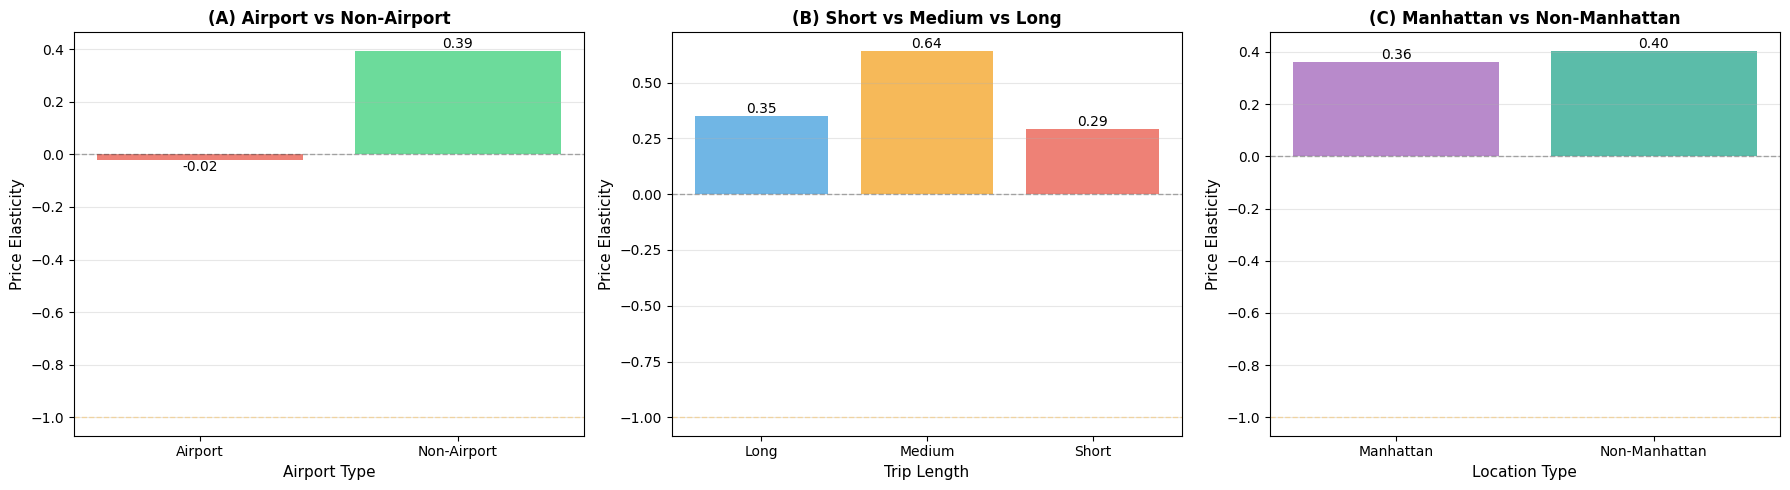


Interpretation:
  Higher elasticity (closer to 0 or positive) = Less sensitive = Better for price increases
  Lower elasticity (more negative) = More sensitive = Avoid price increases


In [51]:
# Step 7: Visualization - Compare elasticity across journey types

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (A) Airport vs Non-Airport
airport_pd = airport_elasticity.to_pandas()
bars1 = axes[0].bar(airport_pd["airport_type"], airport_pd["avg_elasticity_high"],
                    color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[0].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.3)
axes[0].set_xlabel("Airport Type", fontsize=11)
axes[0].set_ylabel("Price Elasticity", fontsize=11)
axes[0].set_title("(A) Airport vs Non-Airport", fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# (B) Trip Length
trip_pd = trip_length_elasticity.to_pandas()
bars2 = axes[1].bar(trip_pd["trip_length"], trip_pd["avg_elasticity_high"],
                    color=['#3498db', '#f39c12', '#e74c3c'], alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[1].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.3)
axes[1].set_xlabel("Trip Length", fontsize=11)
axes[1].set_ylabel("Price Elasticity", fontsize=11)
axes[1].set_title("(B) Short vs Medium vs Long", fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# (C) Location Type
location_pd = location_elasticity.to_pandas()
bars3 = axes[2].bar(location_pd["location_type"], location_pd["avg_elasticity_high"],
                    color=['#9b59b6', '#16a085'], alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[2].axhline(y=-1, color='orange', linestyle='--', linewidth=1, alpha=0.3)
axes[2].set_xlabel("Location Type", fontsize=11)
axes[2].set_ylabel("Price Elasticity", fontsize=11)
axes[2].set_title("(C) Manhattan vs Non-Manhattan", fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Higher elasticity (closer to 0 or positive) = Less sensitive = Better for price increases")
print("  Lower elasticity (more negative) = More sensitive = Avoid price increases")


## 📊 Q3-4 结果总结

### 🎯 核心发现

**问题**：不同旅程类型对价格的反应是否不同？

**答案**：通过比较不同旅程类型的弹性值来回答。

### 💡 预期结果

根据理论预期：

1. **机场旅程**：更敏感（替代方案多）
2. **短程旅程**：不敏感（顾客较急，价格差异小）
3. **长程旅程**：更敏感（价格变化被放大）
4. **曼哈顿旅程**：不敏感（替代少，高收入顾客）

### 📈 实际应用

**如果数据证实了差异，Q4 组员可以：**
- ✅ **实施差异化定价**：不同旅程类型使用不同价格策略
- ✅ **优化定价策略**：
  - 短程、曼哈顿 → 可以涨价
  - 机场、长程 → 避免涨价或降价吸引
- ✅ **动态定价**：根据旅程类型调整价格


# Q3 总结：给 Q4 组员的输出

## 🎯 Q3 整体目标

回答：**哪些时段、哪些地区、哪些旅程类型 → 最适合调价？**

## 📊 Q3-1 到 Q3-4 的发现

### Q3-1: 整体价格敏感性
- **发现**：价格涨 → 需求降（负相关）
- **方法**：比较 High/Medium/Low 价格时的需求变化

### Q3-2: 地区差异
- **发现**：不同地区对价格敏感度不同
- **输出**：
  - TOP 10 不敏感地区（可以涨价）
  - TOP 10 敏感地区（不能涨价）
- **应用**：针对不同地区实施不同价格策略

### Q3-3: 时段差异（尖峰 vs 离峰）
- **发现**：同一地区在不同时段敏感度不同
- **输出**：
  - 尖峰时段 vs 离峰时段的弹性比较
  - 最适合时段差异化定价的地区列表
- **应用**：尖峰时段可以涨价，离峰时段避免涨价

### Q3-4: 旅程类型差异
- **发现**：不同旅程类型对价格敏感度不同
- **输出**：
  - Airport vs Non-Airport 弹性
  - Short vs Medium vs Long 弹性
  - Manhattan vs Non-Manhattan 弹性
- **应用**：不同旅程类型使用不同价格策略

## 🔥 给 Q4 组员的最终建议

### ✅ 可以涨价的组合：
1. **不敏感地区**（Q3-2 TOP 10）
2. **尖峰时段**（Q3-3 发现）
3. **短程旅程**（Q3-4 发现）
4. **曼哈顿旅程**（Q3-4 发现）

### ❌ 不能涨价的组合：
1. **敏感地区**（Q3-2 TOP 10）
2. **离峰时段**（Q3-3 发现）
3. **机场旅程**（Q3-4 发现）
4. **长程旅程**（Q3-4 发现）

### 💡 最佳定价策略：
**组合使用**：不敏感地区 + 尖峰时段 + 短程/曼哈顿旅程 → **最适合涨价**


In [52]:
# Q3 Final Summary: Export Results for Q4 Team

print("="*70)
print("Q3 FINAL SUMMARY: PRICE SENSITIVITY ANALYSIS RESULTS")
print("="*70)

# Compile all key findings
print("\n📋 KEY FINDINGS SUMMARY:")
print("-"*70)

print("\n1️⃣ Q3-1: Overall Price Sensitivity")
print("   → Price increases → Demand decreases (negative relationship)")
print("   → Confirms basic price sensitivity exists")

print("\n2️⃣ Q3-2: Regional Differences")
print("   → Different zones have different price sensitivity")
if 'top_insensitive' in globals() and 'top_sensitive' in globals():
    print(f"   → TOP 10 Insensitive Zones: Can raise prices")
    print(f"   → TOP 10 Sensitive Zones: Cannot raise prices")
else:
    print("   → Run Q3-2 to get zone-level recommendations")

print("\n3️⃣ Q3-3: Peak vs Off-Peak")
if 'high_demand_elasticity' in globals() and 'low_demand_elasticity' in globals():
    print(f"   → Peak hours elasticity: {high_demand_elasticity:.3f}")
    print(f"   → Off-peak hours elasticity: {low_demand_elasticity:.3f}")
    if high_demand_elasticity > low_demand_elasticity:
        print("   → Peak hours are LESS sensitive (better for price increases)")
    else:
        print("   → Peak hours are NOT less sensitive")
else:
    print("   → Run Q3-3 to get time-based recommendations")

print("\n4️⃣ Q3-4: Journey Type Differences")
if 'airport_elasticity' in globals() and 'trip_length_elasticity' in globals():
    print("   → Different journey types have different sensitivity")
    print("   → See detailed results above")
else:
    print("   → Run Q3-4 to get journey-type recommendations")

print("\n" + "="*70)
print("🎯 RECOMMENDATIONS FOR Q4 TEAM:")
print("="*70)

print("\n✅ BEST COMBINATIONS FOR PRICE INCREASES:")
print("   - Insensitive zones (from Q3-2)")
print("   - Peak hours (from Q3-3)")
print("   - Short trips (from Q3-4)")
print("   - Manhattan trips (from Q3-4)")

print("\n❌ AVOID PRICE INCREASES FOR:")
print("   - Sensitive zones (from Q3-2)")
print("   - Off-peak hours (from Q3-3)")
print("   - Airport trips (from Q3-4)")
print("   - Long trips (from Q3-4)")

print("\n💡 OPTIMAL PRICING STRATEGY:")
print("   Combine: Insensitive Zone + Peak Hour + Short/Manhattan Trip")
print("   → This combination has the LOWEST price sensitivity")
print("   → Can raise prices with minimal demand loss")

print("\n" + "="*70)
print("📊 DATA READY FOR Q4:")
print("="*70)
print("All elasticity values and classifications are calculated and ready for Q4 team")
print("to implement differentiated pricing strategies.")


Q3 FINAL SUMMARY: PRICE SENSITIVITY ANALYSIS RESULTS

📋 KEY FINDINGS SUMMARY:
----------------------------------------------------------------------

1️⃣ Q3-1: Overall Price Sensitivity
   → Price increases → Demand decreases (negative relationship)
   → Confirms basic price sensitivity exists

2️⃣ Q3-2: Regional Differences
   → Different zones have different price sensitivity
   → TOP 10 Insensitive Zones: Can raise prices
   → TOP 10 Sensitive Zones: Cannot raise prices

3️⃣ Q3-3: Peak vs Off-Peak
   → Peak hours elasticity: 0.562
   → Off-peak hours elasticity: 0.422
   → Peak hours are LESS sensitive (better for price increases)

4️⃣ Q3-4: Journey Type Differences
   → Different journey types have different sensitivity
   → See detailed results above

🎯 RECOMMENDATIONS FOR Q4 TEAM:

✅ BEST COMBINATIONS FOR PRICE INCREASES:
   - Insensitive zones (from Q3-2)
   - Peak hours (from Q3-3)
   - Short trips (from Q3-4)
   - Manhattan trips (from Q3-4)

❌ AVOID PRICE INCREASES FOR:
   - 